# Import Packages

In [ ]:
#importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
root_path ='/content/drive/MyDrive/AML-Airbnb New User Booking Challenge/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv(f'{root_path}dataset/train_users_2.csv')
df_test = pd.read_csv(f'{root_path}dataset/test_users.csv')
df_train.shape, df_test.shape

((213451, 16), (62096, 15))

In [ ]:
labels = df_train.country_destination.values
id_test = df_test.id
df_train.drop(['country_destination'], axis = 1)
#Concatenating train and test data for EDA
df_all = pd.concat((df_train, df_test), axis = 0, ignore_index= True)

In [ ]:
df_all.shape

(275547, 16)

In [ ]:
df_all.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


# Data Assessment

In [ ]:
#Finding the number of null entries in each column.
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(i + " has {} null values.".format(ab))
        print()

date_first_booking has 186639 null values.

age has 116866 null values.

first_affiliate_tracked has 6085 null values.

country_destination has 62096 null values.



In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  firs

In [ ]:
session_data1 = pd.read_csv("/content/drive/MyDrive/AML-Airbnb New User Booking Challenge/dataset/sessions.csv")
session_data1.user_id.unique()

array(['d1mm9tcy42', 'yo8nz8bqcq', '4grx6yxeby', ..., 'fa6260ziny',
       '87k0fy4ugm', '9uqfg8txu3'], dtype=object)

In [ ]:
from copy import deepcopy
session_data = deepcopy(session_data1)

In [ ]:
session_data = pd.read_csv("/content/drive/MyDrive/AML-Airbnb New User Booking Challenge/dataset/sessions.csv")
session_data.secs_elapsed.fillna(0, inplace=True)
session_data['is_live_action'] = session_data.secs_elapsed.apply(lambda x : True if x < 60 else False)
session_data['is_typeB_action'] = session_data.secs_elapsed.apply(lambda x : True if x >= 60 and x <=600 else False)
session_data['is_typeC_action'] = session_data.secs_elapsed.apply(lambda x : True if x > 600 and x <=7200 else False)
session_data['is_typeD_action'] = session_data.secs_elapsed.apply(lambda x : True if x > 7200 and x <=86400 else False)
session_data['is_typeE_action'] = session_data.secs_elapsed.apply(lambda x : True if x > 86400 else False)
total_session_by_type = session_data.groupby("user_id", as_index = False).sum()
total_session_by_type.columns = ['user_id', 'secs_elapsed', 'total_quick_actions', 'total_careful_actions',
       'total_pause_actions', 'total_afk_actions', 'total_long_afk_actions']
all_merge = df_all.merge(total_session_by_type, left_on='id', right_on='user_id', how='left').drop("user_id", axis = 1)

In [ ]:
total_session_by_type = session_data.groupby("user_id", as_index = False).sum()

In [ ]:
total_session_by_type

,user_id,secs_elapsed,is_live_action,is_typeB_action,is_typeC_action,is_typeD_action,is_typeE_action
0,00023iyk9l,867896.0,4,10,18,6,2
1,0010k6l0om,586543.0,13,14,21,13,2
2,001wyh0pz8,282965.0,2,18,61,9,0
3,0028jgx1x1,297010.0,5,11,4,11,0
4,002qnbzfs5,6487080.0,162,246,275,93,13
...,...,...,...,...,...,...,...
135478,zzxox7jnrx,639436.0,11,20,35,22,1
135479,zzy7t0y9cm,73771.0,2,1,3,2,0
135480,zzysuoqg6x,1731.0,1,1,1,0,0
135481,zzywmcn0jv,2149949.0,10,5,22,9,5


In [ ]:
session_data1 

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [ ]:
all_merge = df_all.merge(total_session_by_type, left_on='id', right_on='user_id', how='left').drop("user_id", axis = 1)

print("All  :",df_all.shape)

print("Session:",total_session_by_type.shape)

print("Merge  :",all_merge.shape)

print("No of users in all Data with session info:",all_merge.shape[0])

# print("{} / {} = {}".format(all_merge.shape[0],df_all.shape[0],np.round((all_merge.shape[0]/df_all.shape[0]),2)))

All  : (275547, 16)
Session: (135483, 7)
Merge  : (275547, 22)
No of users in all Data with session info: 275547


In [ ]:
all_merge

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app,first_device_type,first_browser,country_destination,secs_elapsed,is_live_action,is_typeB_action,is_typeC_action,is_typeD_action,is_typeE_action
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,...,Web,Mac Desktop,Chrome,NDF,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,...,Web,Mac Desktop,Chrome,NDF,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,Web,Windows Desktop,IE,US,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,Web,Mac Desktop,Firefox,other,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,...,Web,Mac Desktop,Chrome,US,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275542,cv0na2lf5a,2014-09-30,20140930235232,NaN,-unknown-,31.0,basic,0,en,direct,...,Web,Windows Desktop,IE,NaN,2534232.0,5.0,11.0,32.0,44.0,1.0
275543,zp8xfonng8,2014-09-30,20140930235306,NaN,-unknown-,NaN,basic,23,ko,direct,...,Android,Android Phone,-unknown-,NaN,51618.0,3.0,7.0,8.0,2.0,0.0
275544,fa6260ziny,2014-09-30,20140930235408,NaN,-unknown-,NaN,basic,0,de,direct,...,Web,Windows Desktop,Firefox,NaN,823297.0,6.0,19.0,31.0,20.0,2.0
275545,87k0fy4ugm,2014-09-30,20140930235430,NaN,-unknown-,NaN,basic,0,en,sem-brand,...,Web,Mac Desktop,Safari,NaN,352068.0,2.0,2.0,6.0,4.0,1.0


In [ ]:
#merge between session and train dataset
all_merge_2 = df_train.merge(session_data1, left_on='id', right_on='user_id', how='inner').drop("user_id", axis = 1)

#action related counts after merging session and train dataset
action_type_count = all_merge_2['action_type'].nunique()
action_detail_count = all_merge_2['action_detail'].nunique()
action_count = all_merge_2['action'].nunique()
count = action_type_count, action_detail_count, action_count
print(count)

#percentage of missing values in said category
percent_missing_action_detail = round(all_merge_2['action_detail'].isna().sum()/len(all_merge_2.index),2)
percent_missing_action = round(all_merge_2['action'].isna().sum()/len(all_merge_2.index),2)
percent = percent_missing_action_detail, percent_missing_action
print(percent)

(9, 128, 331)
(0.11, 0.01)


In [ ]:
session_data1

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [ ]:
df_all = all_merge.drop(['id','country_destination','date_first_booking'], axis = 1)

In [ ]:
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(i + " has {} null values.".format(ab))
        print()

age has 116866 null values.

first_affiliate_tracked has 6085 null values.

secs_elapsed has 140064 null values.

is_live_action has 140064 null values.

is_typeB_action has 140064 null values.

is_typeC_action has 140064 null values.

is_typeD_action has 140064 null values.

is_typeE_action has 140064 null values.



In [ ]:
df_all.head()

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,secs_elapsed,is_live_action,is_typeB_action,is_typeC_action,is_typeD_action,is_typeE_action
0,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_all.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [ ]:
df_all.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [ ]:
df_all[df_all['age']<15].age = np.nan
df_all[df_all['age']>=100].age = np.nan

In [ ]:
#Converting below columns as categories for plotting in graphs
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')

In [ ]:
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'])
df_all['timestamp_first_active'] = pd.to_datetime(df_all['timestamp_first_active'], format='%Y%m%d%H%M%S')

# Visualizations

#### Univariate plots

In [ ]:
sns.set_style('whitegrid')
sns.set_context("talk")

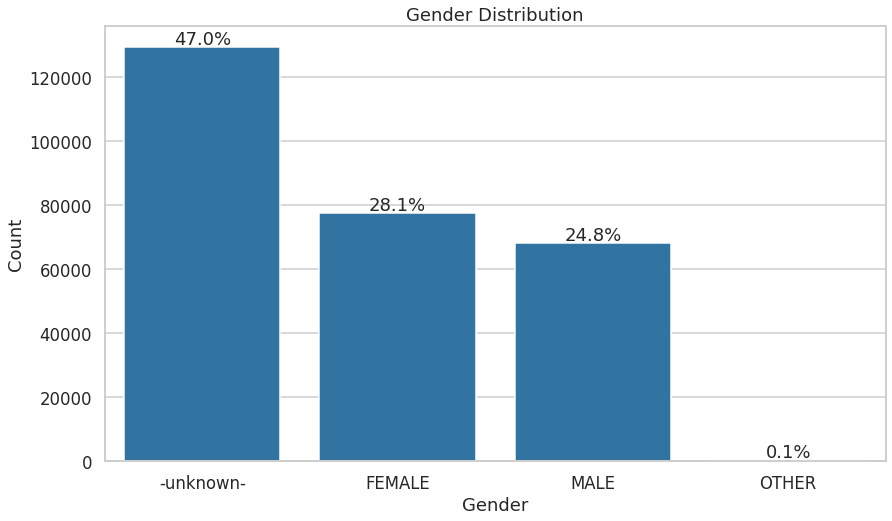

In [ ]:
#Finding the gender distribution

plt.figure(figsize=(14,8))
order1 = df_all['gender'].value_counts().index
sns.countplot(data = df_all, x = 'gender', order = order1, color = sns.color_palette()[0])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
order2 = df_all['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_all.shape[0])
    plt.text(i,count+1000,strt,ha='center')

Since, the provision of gender information cannot be mandated, we observe a lot of records where people perhaps chose not to disclose their gender info which probably got recoerded as "-unknown-" in the database.

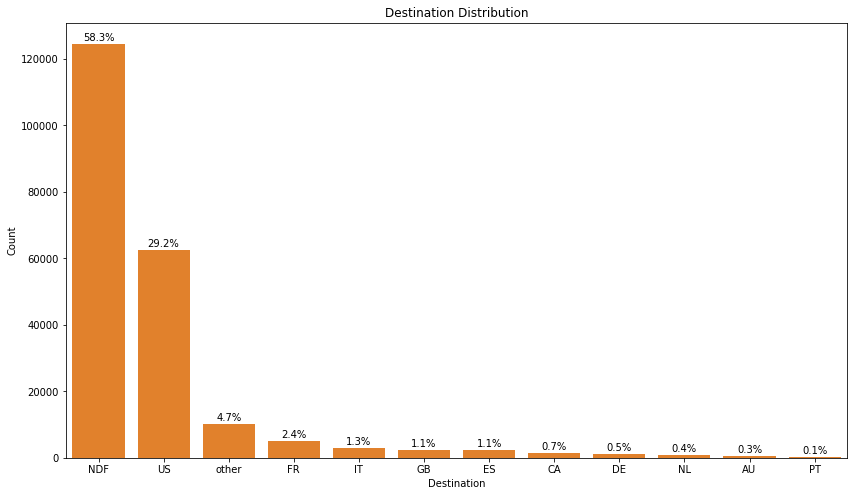

In [ ]:
#Finding Destination Distribution.

plt.figure(figsize=(14,8))
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order = order1, color = sns.color_palette()[1])
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Destination Distribution')
order2 = df_train['country_destination'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_train.shape[0])
    plt.text(i,count+1000,strt,ha='center')

We can observe how imbalanced our dataset is but it is to be noted that this is representative of the real life scenario which AirBnB faces. In order to improve the efficiency of the model. a real distinction should be made between NDF (no destination found) and other countries which would basically help us capture the intent of the user before working on any product features (Ex. Personalized Discounts, offers) that target such users. 

In [ ]:
#Extracting year for date_account_created
df_all['acc_year'] = df_all['date_account_created'].dt.year


df1 = df_all.groupby('acc_year').count()
df1.head()

years = [2010,2011,2012,2013,2014]
yearsOrder=pd.api.types.CategoricalDtype(ordered=True, categories=years)
df1.reset_index(inplace = True)
df1.acc_year = df1.acc_year.astype(yearsOrder)

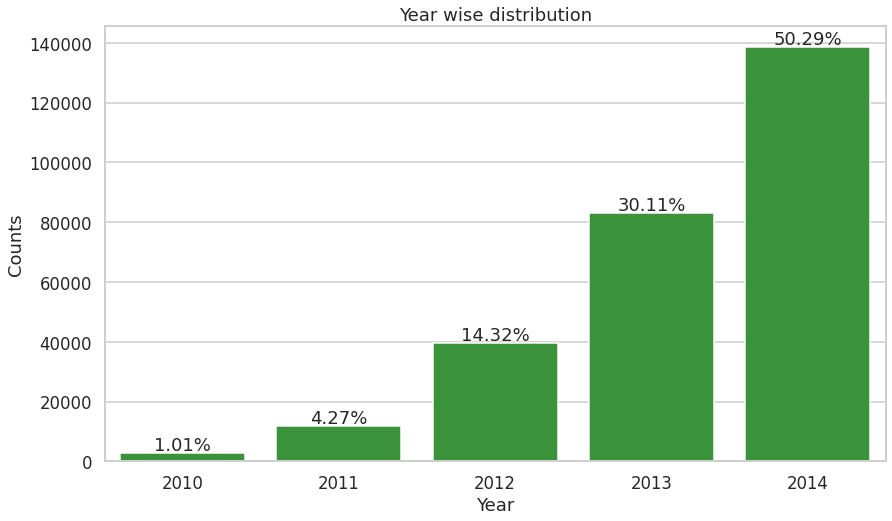

In [ ]:
#Finding year-wise distribution

plt.figure(figsize=[14,8])
sns.barplot(data=df1,x='acc_year',y='affiliate_provider',color=sns.color_palette()[2]);
plt.title('Year wise distribution');
plt.xlabel('Year')
plt.ylabel('Counts')
for i in range(df1.shape[0]):
    count=df1.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+1000,strt,ha='center')

In [ ]:
# Creating a month centered dataframe for 2014
df2 = df_all[df_all['date_account_created'].dt.year==2014]
df2['monthYear14'] = df2['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df2 = df2.groupby('monthYear14').count()

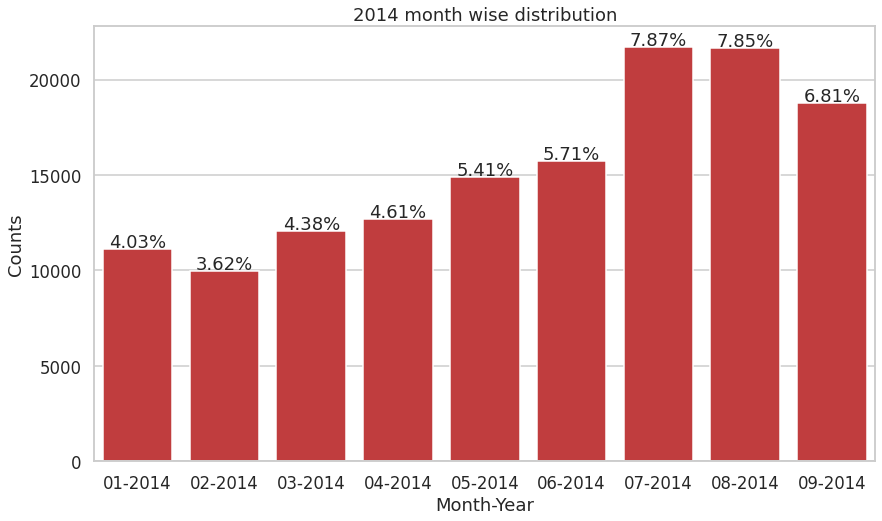

In [ ]:
#Number of accounts created in different month of 2014

plt.figure(figsize=[14,8])
sns.barplot(data=df2,x=df2.index,y='affiliate_provider',color=sns.color_palette()[3]);
plt.title('2014 month wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')
for i in range(df2.shape[0]):
    count=df2.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+100,strt,ha='center')

We can observe that most activity is accumulated in the months corresponding to vacation and holidays.

In [ ]:
#Dividing member ages into various bins

df_all['member_age_bins']=df_all['age'].apply(lambda x: '18 - 20' if 18<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else '60-70' if 60<x<=70
                                                  else '70+' if 70<x<=100
                                                  else np.nan)

In [ ]:
df_all.head()

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,first_device_type,first_browser,secs_elapsed,is_live_action,is_typeB_action,is_typeC_action,is_typeD_action,is_typeE_action,acc_year,member_age_bins
0,2010-06-28,2009-03-19 04:32:55,-unknown-,NaN,facebook,0,en,direct,direct,untracked,...,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN,2010,NaN
1,2011-05-25,2009-05-23 17:48:09,MALE,38.0,facebook,0,en,seo,google,untracked,...,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN,2011,30 - 40
2,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,untracked,...,Windows Desktop,IE,NaN,NaN,NaN,NaN,NaN,NaN,2010,50 - 60
3,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,untracked,...,Mac Desktop,Firefox,NaN,NaN,NaN,NaN,NaN,NaN,2011,40 - 50
4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.0,basic,0,en,direct,direct,untracked,...,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN,2010,40 - 50


In [ ]:
# Creating a month centered dataframe for 2014

df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df3 = df3.groupby('monthYear13').count()

In [ ]:
df_all[df_all['date_account_created'].dt.year==2013]

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,first_device_type,first_browser,secs_elapsed,is_live_action,is_typeB_action,is_typeC_action,is_typeD_action,is_typeE_action,acc_year,member_age_bins
2446,2013-03-22,2010-11-22 19:37:44,-unknown-,34.0,basic,0,en,direct,direct,untracked,...,Mac Desktop,Safari,NaN,NaN,NaN,NaN,NaN,NaN,2013,30 - 40
2537,2013-08-22,2010-12-01 14:30:12,FEMALE,38.0,basic,0,en,direct,direct,untracked,...,Mac Desktop,Safari,NaN,NaN,NaN,NaN,NaN,NaN,2013,30 - 40
2817,2013-09-26,2011-01-02 23:50:14,FEMALE,NaN,basic,0,en,sem-brand,google,omg,...,Windows Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN,2013,NaN
4202,2013-04-03,2011-04-12 23:22:01,MALE,48.0,basic,0,en,direct,direct,untracked,...,Mac Desktop,Safari,NaN,NaN,NaN,NaN,NaN,NaN,2013,40 - 50
6113,2013-08-06,2011-06-30 20:43:58,FEMALE,30.0,basic,0,en,direct,direct,untracked,...,Windows Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN,2013,20 - 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137016,2013-12-31,2013-12-31 23:44:48,FEMALE,29.0,facebook,0,en,sem-brand,google,linked,...,Windows Desktop,IE,NaN,NaN,NaN,NaN,NaN,NaN,2013,20 - 30
137017,2013-12-31,2013-12-31 23:50:53,-unknown-,NaN,basic,0,en,direct,direct,untracked,...,Windows Desktop,IE,NaN,NaN,NaN,NaN,NaN,NaN,2013,NaN
137018,2013-12-31,2013-12-31 23:52:14,FEMALE,36.0,basic,0,en,direct,direct,untracked,...,Windows Desktop,IE,NaN,NaN,NaN,NaN,NaN,NaN,2013,30 - 40
137019,2013-12-31,2013-12-31 23:58:33,-unknown-,NaN,basic,0,en,direct,direct,linked,...,Mac Desktop,Firefox,NaN,NaN,NaN,NaN,NaN,NaN,2013,NaN


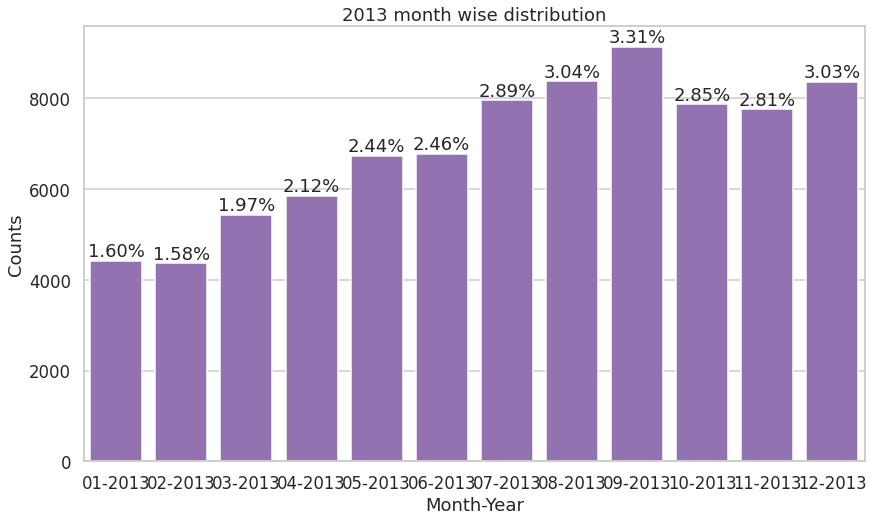

In [ ]:
#Number of accounts created in different month of 2014

plt.figure(figsize=[14,8])
sns.barplot(data=df3,x=df3.index,y='affiliate_provider',color=sns.color_palette()[4]);
plt.title('2013 month wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')
for i in range(df3.shape[0]):
    count=df3.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+100,strt,ha='center')

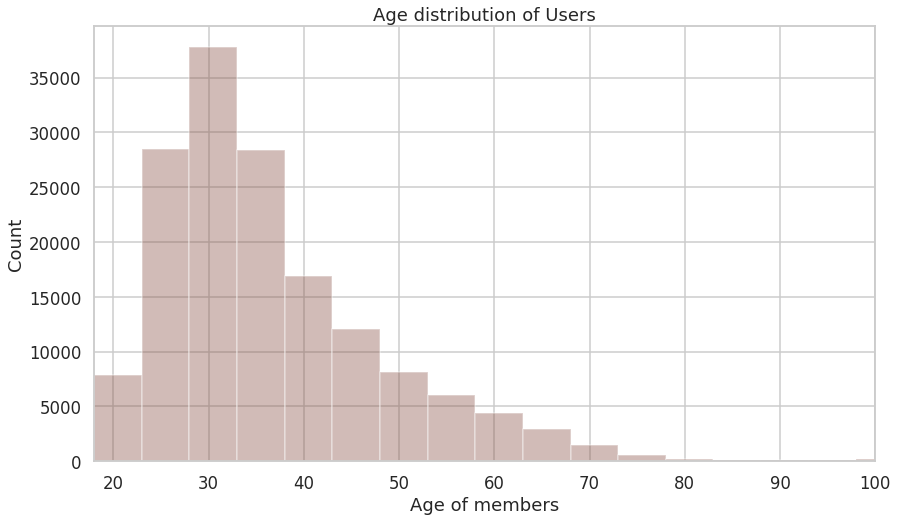

In [ ]:
#Plotting Age distribution of the members
plt.figure(figsize=[14,8])
sns.distplot(df_all.age.dropna(),bins=np.arange(18,100+5,5),color=sns.color_palette()[5],kde=False);
plt.xlabel('Age of members')
plt.ylabel('Count')
plt.title('Age distribution of Users')
plt.xlim(18,100);

#### Bivariate Plots

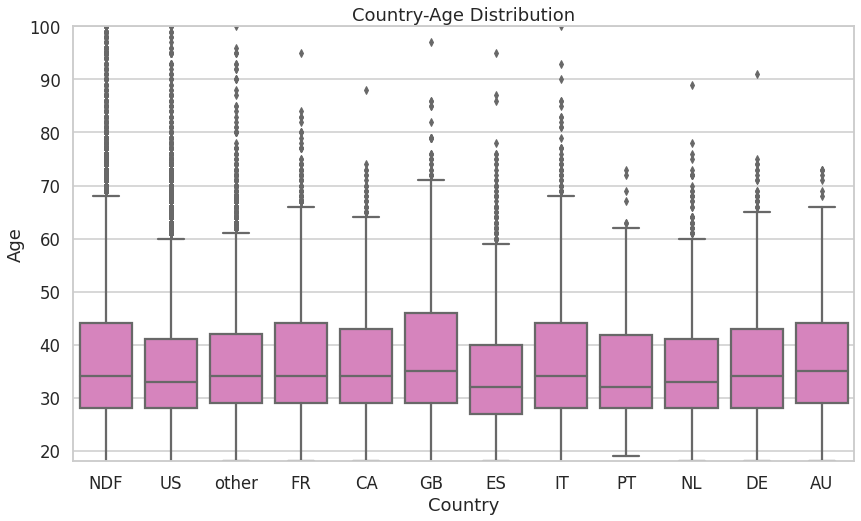

In [ ]:
#Destination-Age distribution plot

plt.figure(figsize=[14,8])
sns.boxplot(data=df_train,y='age',x='country_destination',color=sns.color_palette()[6]);
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution');

From the above plot, we can see that we need to handle the outliers for the age attribute before we proceed with model building.

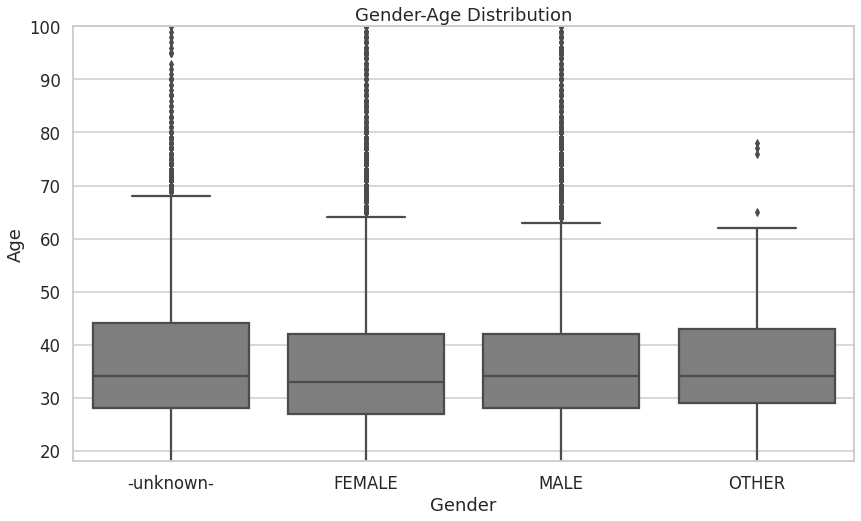

In [ ]:
#Gender-Age Distribution plot

plt.figure(figsize=[14,8])
sns.boxplot(data=df_all,y='age',x='gender',color=sns.color_palette()[7]);
plt.ylim(18,100)
plt.xlabel('Gender');
plt.ylabel('Age');
plt.title('Gender-Age Distribution');

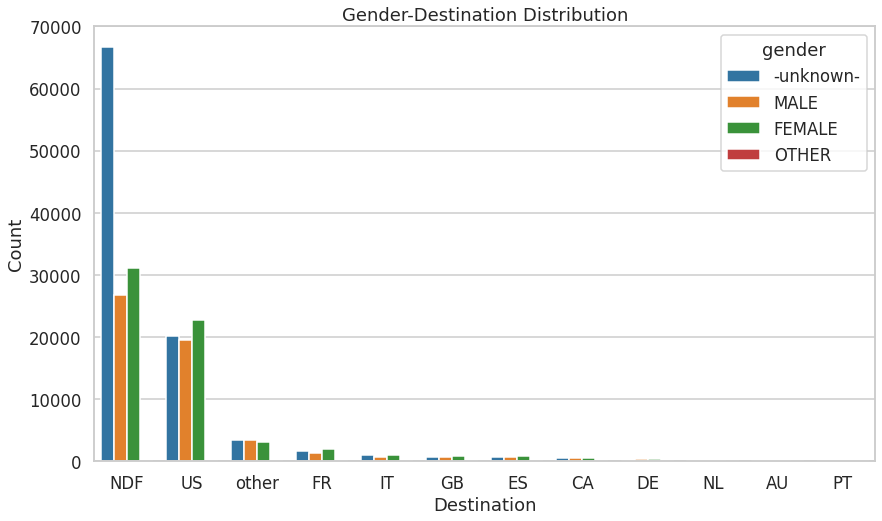

In [ ]:
#Gender-Destination Distribution Plot

plt.figure(figsize=(14,8))
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order = order1,hue='gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Gender-Destination Distribution')
order2 = df_train['country_destination'].value_counts()

In [ ]:
df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df3= df3.groupby(['monthYear13','member_age_bins']).count()

df3.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

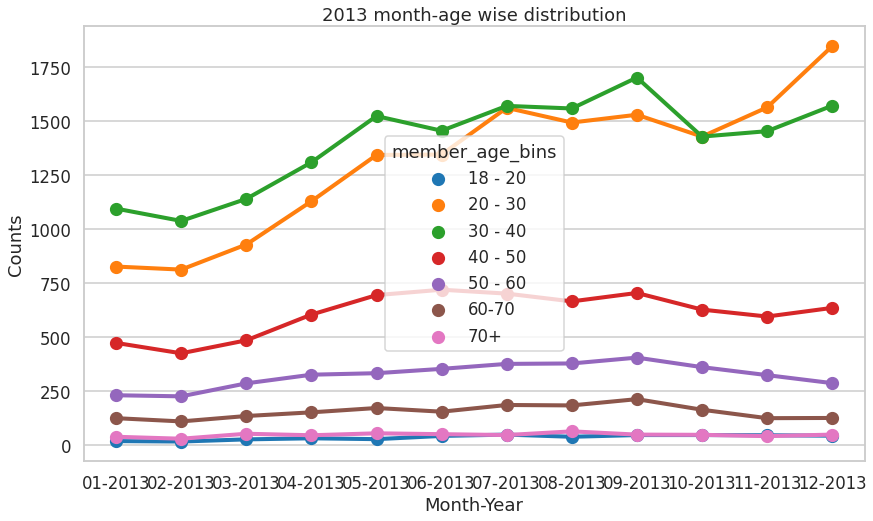

In [ ]:
#Age wise distribution of the booking in different months of 2013

plt.figure(figsize=[14,8])
sns.pointplot(data=df3,x='monthYear13',y='affiliate_provider',hue='member_age_bins');
plt.title('2013 month-age wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

In [ ]:
df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df3= df3.groupby(['monthYear13','gender']).count()

df3.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

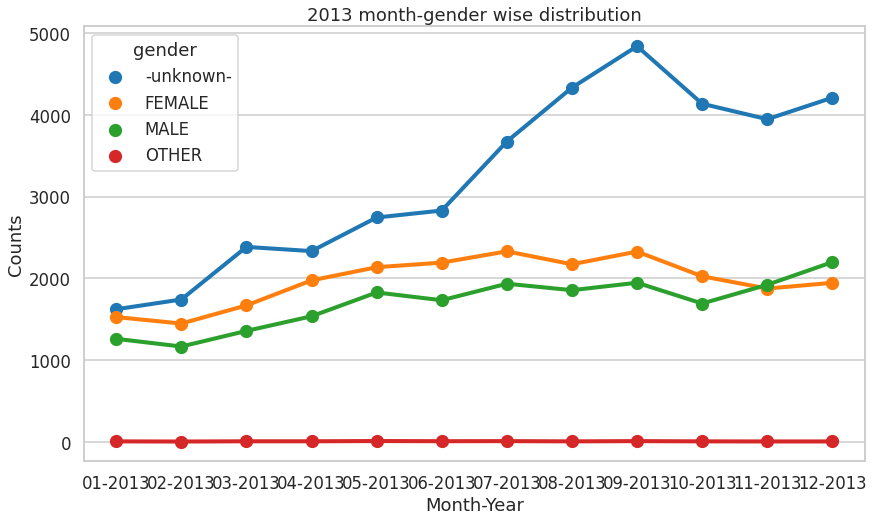

In [ ]:
#Gender wise distribution of the booking in different months of 2013

plt.figure(figsize=[14,8])
sns.pointplot(data=df3,x='monthYear13',y='affiliate_provider',hue='gender');
plt.title('2013 month-gender wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

#### Multivariate Plot

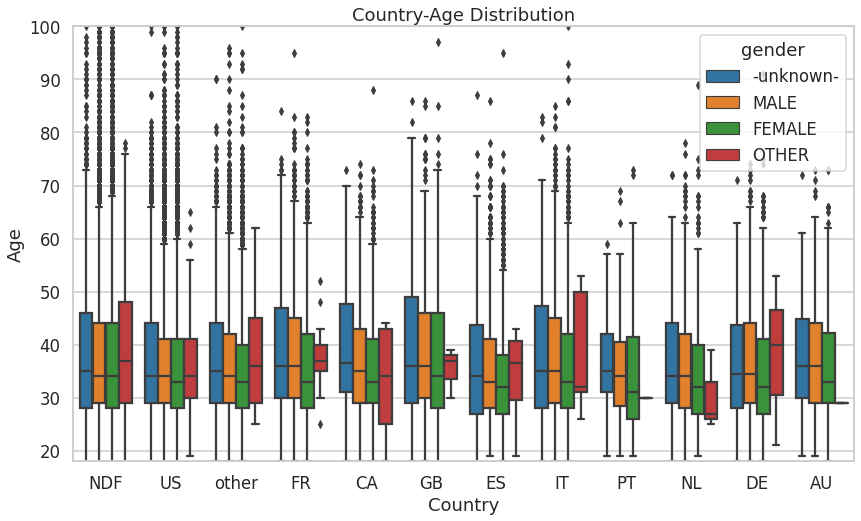

In [ ]:
#Relationship between age-gender-destination

plt.figure(figsize=[14,8])
sns.boxplot(data=df_train,y='age',x='country_destination',hue='gender');
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution');

# Conclusion

From the EDA we performed, we now have a better understanding of the data and collected insights on how engineer more relavant features along with handling the imbalanced data we have for the model building.